# Задача 3. Сравнение методов классификации

## Список задач
1. Самостоятельно реализовать один из методов классификации, с возможностью настройки гиперпараметров.
2. Взять данные для предсказания заболеваний сердца.
3. Считать данные, выполнить первичный анализ данных, при необходимости произвести чистку данных (Data Cleaning).
4. Выполнить разведочный анализ (EDA), использовать визуализацию, сделать выводы, которые могут быть полезны при дальнейшем решении задачи классификации.
5. При необходимости выполнить полезные преобразования данных (например, трансформировать категариальные признаки в количественные), убрать ненужные признаки, создать новые (Feature Engineering).
6. Используя подбор гиперпараметров, кросс-валидацию и при необходимости масштабирование данных, добиться наилучшего качества предсказания от Вашей реализации на выделенной заранее тестовой выборке.
7. Повторить предыдущий пункт для библиотечных реализаций (например, из sklearn) всех пройденных методов классификации (logistic regression, svm, knn, naive bayes, decision tree).
8. Сравнить все обученные модели, построить их confusion matrices. Сделать выводы о полученных моделях в рамках решения задачи классификации на выбранных данных.
9. Реализовать еще один из методов классификации и добавить его в сравнение.
10. Найти данные, на которых интересно будет решать задачу классификации. Повторить все пункты задания на новых данных.

In [21]:
from typing import Union

import numpy as np
from numpy.typing import NDArray
import pandas as pd
import polars as pl
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_validate
from sklearn.metrics import confusion_matrix, roc_auc_score, f1_score
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt

# 1/9. Самостоятельно реализовать два метода классификации, с возможностью настройки гиперпараметров.
Реализую дерево решений (Decision Tree) по алгоритму CART и метод опорных векторов (Support Vector Machine)

## Дерево решений

In [5]:
class Metrics:
    """
    Класс метрик качества для задач классификации и кластеризации
    """
    
    @staticmethod
    def gini(y: np.ndarray) -> float:
        """
        Вычисляем коэффициент Gini для вектора целевых переменных

        Параметры:
            y (np.ndarray): Одномерный массив (целочисленный вектор)

        Возвращает:
            float: Значение коэффициента Gini
        """
        count_targets = len(y)
        if count_targets == 0:
            return 0.0

        _, count_each_target = np.unique(y, return_counts=True)
        probabilities = count_each_target / count_targets
        return 1 - np.sum(probabilities ** 2)

    @staticmethod
    def gini_split(left_y: np.ndarray, right_y: np.ndarray) -> float:
        """
        Вычисляем коэффициент Gini для узла при выбранном пороге

        Параметры:
            left_y: Массив целевых переменных для левой ветви.
            right_y: Массив целевых переменных для правой ветви.

        Возвращает:
            float: Взвешенное значение Gini для разбиения.
        """
        count_objects = len(left_y) + len(right_y)

        left_leaf_loss = Metrics.gini(left_y)
        right_leaf_loss = Metrics.gini(right_y)
        weighted_gini = ((len(left_y) / count_objects) * left_leaf_loss) + \
                        ((len(right_y) / count_objects) * right_leaf_loss)

        return weighted_gini, left_leaf_loss, right_leaf_loss

class Node:
    """
    Класс узла дерева

    Параметры:
        X: подвыборка признаков в узле
        y: подвыборка целевых переменных в узле
    """

    def __init__(self, X: pl.DataFrame = None, y: np.ndarray = None, depth: int = 0):
        self.left_node = None
        self.right_node = None

        self.X = X
        self.y = y

        self.feature = None
        self.threshold = None

        self.score = Metrics.gini(y) if y is not None else None

        self.depth = depth

    def create_child_nodes(self, metric='Gini', max_depth=3, min_samples_split=2):
        """
        Функция создания дочерних узлов, присвоение им выборки соответствующих целевых переменных

        Параметры:
            metric: выбранная метрика качества
            max_depth: максимальная глубина дерева
            min_samples_split: минимальное количество образцов для разделения

        Возвращает:
            None
        """
        if self.depth >= max_depth or len(self.y) < min_samples_split or self.score == 0:
            return

        best_feature, best_threshold, best_score, left_indices, right_indices = self.__choose_best_split(metric)
        if best_feature is None:
            return

        self.feature = best_feature
        self.threshold = best_threshold

        X_left = self.X[left_indices]
        y_left = self.y[left_indices]
        X_right = self.X[right_indices]
        y_right = self.y[right_indices]

        self.left_node = Node(X_left, y_left, depth=self.depth + 1)
        self.right_node = Node(X_right, y_right, depth=self.depth + 1)

        self.left_node.create_child_nodes(metric, max_depth, min_samples_split)
        self.right_node.create_child_nodes(metric, max_depth, min_samples_split)

    def __choose_best_split(self, metric='Gini'):
        """
        Вычисляет оптимальный признак и порог для узла, исходя из выбранной метрики

        Возвращает:
            best_feature, best_threshold, best_score, left_indices, right_indices
        """
        best_feature = None
        best_threshold = None
        best_score = np.inf
        best_left_indices = None
        best_right_indices = None

        features = self.X.columns

        for feature in features:
            X_column = self.X[feature].to_numpy()
            thresholds, scores, left_indices_list, right_indices_list = self.__find_thresholds(X_column, self.y, metric)

            if len(scores) == 0:
                continue

            min_score_index = np.argmin(scores)
            score = scores[min_score_index]
            if score < best_score:
                best_score = score
                best_threshold = thresholds[min_score_index]
                best_feature = feature
                best_left_indices = left_indices_list[min_score_index]
                best_right_indices = right_indices_list[min_score_index]

        return best_feature, best_threshold, best_score, best_left_indices, best_right_indices

    def __find_thresholds(self, X_column: np.ndarray, y: np.ndarray, metric='Gini'):
        """
        Находит все возможные пороги для признака и вычисляет метрику для каждого

        Возвращает:
            thresholds, scores, left_indices_list, right_indices_list
        """
        thresholds = []
        scores = []
        left_indices_list = []
        right_indices_list = []

        sorted_indices = np.argsort(X_column)
        X_sorted = X_column[sorted_indices]
        y_sorted = y[sorted_indices]

        unique_values = np.unique(X_sorted)
        if len(unique_values) == 1:
            return thresholds, scores, left_indices_list, right_indices_list

        for i in range(1, len(X_sorted)):
            if X_sorted[i] == X_sorted[i - 1]:
                continue  # пропускаем повторяющиеся значения

            threshold = (X_sorted[i] + X_sorted[i - 1]) / 2

            left_indices = sorted_indices[:i]
            right_indices = sorted_indices[i:]

            left_y = y[left_indices]
            right_y = y[right_indices]

            if metric == 'Gini':
                score, _, _ = Metrics.gini_split(left_y, right_y)
            else:
                raise ValueError(f"Неизвестная метрика: {metric}")

            thresholds.append(threshold)
            scores.append(score)
            left_indices_list.append(left_indices)
            right_indices_list.append(right_indices)

        return thresholds, scores, left_indices_list, right_indices_list

    def majority_class(self):
        """
        Возвращает класс большинства в листе.
        """
        values, counts = np.unique(self.y, return_counts=True)
        return values[np.argmax(counts)]

class DecisionTree:
    """
    Класс решающего дерева, реализованного по алгоритму CART

    Параметры:
        max_depth: максимальная глубина дерева
        metric: метрика качества
    """
    
    def __init__(self, max_depth: int = 3, metric: str = 'Gini', min_samples_split: int = 2):
        self.max_depth = max_depth
        self.metric = metric
        self.min_samples_split = min_samples_split
        self.root = None
    
    def encode_categorical_features(self, X: pl.DataFrame):
        """
        Метод кодирования категориальных переменных с помощью One-Hot Encoding

        Параметры:
            X: датафрейм данных

        Возвращает:
            pl.DataFrame: датафрейм данных с закодированными категориальными переменными
        """
        categorical_features = [feature for feature, dtype in X.schema.items() if dtype == pl.Utf8]
        if len(categorical_features) == 0:
            return X

        X_encoded = X.to_pandas()
        X_encoded = pd.get_dummies(X_encoded, columns=categorical_features)
        return pl.from_pandas(X_encoded)
    
    def fit(self, X: Union[np.ndarray, pd.DataFrame, pl.DataFrame], y: np.ndarray):
        """
        Метод построения решающего дерева на основе данных

        Параметры:
            X: датафрейм данных
            y: вектор целевых переменных

        Возвращает:
            self
        """
        # Преобразование данных в pl.DataFrame
        if isinstance(X, pd.DataFrame):
            X = pl.from_pandas(X)
        elif isinstance(X, np.ndarray):
            X = pl.DataFrame(X)
        elif not isinstance(X, pl.DataFrame):
            raise ValueError("X должен быть pd.DataFrame, pl.DataFrame или np.ndarray")

        # Кодирование категориальных признаков
        X = self.encode_categorical_features(X)

        self.features = X.columns

        self.root = Node(X, y, depth=0)
        self.root.create_child_nodes(metric=self.metric, max_depth=self.max_depth, min_samples_split=self.min_samples_split)
        return self
    
    def predict(self, X: Union[np.ndarray, pd.DataFrame, pl.DataFrame]) -> np.ndarray:
        """
        Метод предсказания целевой метки объектов

        Параметры:
            X: датафрейм данных

        Возвращает:
            np.ndarray: список предсказанных целевых меток
        """
        # Преобразование данных в pl.DataFrame
        if isinstance(X, pd.DataFrame):
            X = pl.from_pandas(X)
        elif isinstance(X, np.ndarray):
            X = pl.DataFrame(X, columns=self.features)
        elif not isinstance(X, pl.DataFrame):
            raise ValueError("X должен быть pd.DataFrame, pl.DataFrame или np.ndarray")

        # Кодирование категориальных признаков
        X = self.encode_categorical_features(X)

        y_pred = []
        
        for row_idx in range(X.height):
            current_node = self.root
            while current_node.left_node is not None and current_node.right_node is not None:
                if current_node.feature not in X.columns:
                    break  # если признак отсутствует после кодирования
                value = X[current_node.feature][row_idx]
                if value <= current_node.threshold:
                    current_node = current_node.left_node
                else:
                    current_node = current_node.right_node
            y_pred.append(current_node.majority_class())
    
        return np.array(y_pred)
    
    def pruning(self, X_val: Union[np.ndarray, pd.DataFrame, pl.DataFrame], y_val: np.ndarray, alpha: float = 0.0):
        """
        Обрезка дерева (pruning) с использованием метода минимальной стоимости сложения (Cost-Complexity Pruning)

        Параметры:
            X_val: валидационные данные
            y_val: целевые метки для валидационных данных
            alpha (float): параметр сложности модели

        Возвращает:
            self
        """
        # Реализация прунинга на основе минимизации функционала с параметром alpha
        # Эта часть может быть довольно сложной и требует полноценной реализации алгоритма CCP
        # Ниже приведен упрощенный пример

        # Вычисляем предсказания на валидационном наборе до прунинга
        y_pred = self.predict(X_val)
        best_accuracy = np.mean(y_pred == y_val)
        best_tree = self.root

        def prune_node(node: Node):
            if node.left_node is None or node.right_node is None:
                return

            # Сохраняем ссылки на дочерние узлы
            left_backup = node.left_node
            right_backup = node.right_node

            # Обрезаем узлы
            node.left_node = None
            node.right_node = None

            # Проверяем качество на валидационной выборке
            y_pred = self.predict(X_val)
            accuracy = np.mean(y_pred == y_val)

            # Если качество улучшилось или не изменилось, оставляем узел обрезанным
            if accuracy >= best_accuracy - alpha:
                best_accuracy = accuracy
                best_tree = self.root
            else:
                # Возвращаем дочерние узлы обратно
                node.left_node = left_backup
                node.right_node = right_backup

                # Рекурсивно пытаемся обрезать дочерние узлы
                prune_node(node.left_node)
                prune_node(node.right_node)

        prune_node(self.root)
        self.root = best_tree
        return self

## Метод опорных векторов

In [ ]:
class LinearSVM:
    """
    Класс метода опорных векторов, линейно разделяющего данные

    Параметры:
        X: датасет признаков
        y: вектор целевых меток
        С: коэффициент регуляризации
        kernel: ядро
    """
    def __init__(self, X: np.ndarray, y: np.ndarray, C: float = 0.0):
        self.X = X
        self.y = y
    
        self.count_objects = self.X.shape[0]
        self.count_features = self.X.shape[1]

        self.C = C
        self.W = np.zeros(self.count_features)
        self.b = 0.0

    def __gradient_descent(self, threshold: float = 1e-3, lr: float = 1e-2, max_iter: int = 10000):
        """
        Подбор параметров линейно разделяющего SVM методом градиентного спуска

        Параметры:
            threshold: порог, если меньше которого будет изменение, то алгоритм остановится
            lr: скорость обучения
            max_iter: максимальное количество итераций

        Возвращает:
            self
        """
        for step in range(max_iter):
            hinge_loss_gradient = 1 - self.y * (self.W.dot(self.X.T) + self.b)
            mask = hinge_loss_gradient > 0

            dW = self.W - self.C * np.sum((self.y[mask][:, None] * self.X[mask, :]), axis=0)
            db = -self.C * np.sum(self.y[mask])

            self.W -= lr * dW
            self.b -= lr * db
            
            # Условие выхода
            if np.linalg.norm(dW) < threshold and abs(db) < threshold:
                break
            
        return self

    def fit(self):
        """
        Обучение классификатора SVM

        Возвращает:
            self
        """
        self.__gradient_descent()
        return self

    def predict(self, X: Union[np.ndarray, pd.DataFrame, pl.DataFrame]):
        if isinstance(X, (pl.DataFrame, pd.DataFrame)):
            X = X.to_numpy()

        if self.W is None or self.b is None:
            raise ValueError("Модель ещё не обучена. Сначала вызовите метод `fit`.")

        decision = np.dot(X, self.W) + self.b
        # Применяем функцию знака
        return np.sign(decision)

class NonlinearSVM:
    """
    Класс метода опорных вектор, нелинейно разделяющего данные

    Параметры:
        X: датасет признаков
        y: вектор целевых меток
        С: коэффициент регуляризации
    """
    def __init__(self, X: np.ndarray, y: np.ndarray, C: float = 0.0):
        self.X = X
        self.y = y
    
        self.count_objects = self.X.shape[0]
        self.count_features = self.X.shape[1]

        self.C = C
        self.W = np.zeros(self.count_features)
        self.b = 0.0

class SVM:
    """
    Класс метода опорных векторов, линейно разделяющего данные

    Параметры:
        X: датасет признаков
        y: вектор целевых меток
        С: коэффициент регуляризации
        kernel: ядро
    """
    def __init__(self, X: Union[np.ndarray, pd.DataFrame, pl.DataFrame], 
                 y: Union[np.ndarray, pd.DataFrame, pl.DataFrame],
                 C: float = 0.0, kernel: str = 'rbf'):
        if isinstance(X, (pl.DataFrame, pd.DataFrame)):
            X = X.to_numpy()
        self.X = X

        if isinstance(y, (pl.DataFrame, pd.DataFrame, pl.Series, pd.Series)):
            y = y.to_numpy()
        self.y = y
    
        self.count_objects = self.X.shape[0]
        self.count_features = self.X.shape[1]

        self.C = C
        self.W = np.zeros(self.count_features)
        self.b = 0.0

        self.kernel = kernel
        self.svm = None

    def __choose_fit_pipeline(self):
        if self.kernel == 'linear':
            self.svm = LinearSVM(self.X_train, self.y_train, C=1.0).fit()
        elif self.kernel == 'rbf':
            self.svm = NonlinearSVM()

    def fit(self):
        """
        Обучение классификатора SVM

        Возвращает:
            self
        """
        self.__choose_fit_pipeline()
        return self

    def __choose_fit_pipeline(self):
        if self.kernel == 'linear':
            self.svm = LinearSVM(self.X_train, self.y_train, C=1.0).predict()
        elif self.kernel == 'rbf':
            self.svm = NonlinearSVM().fit()

    def predict(self, X: Union[np.ndarray, pd.DataFrame, pl.DataFrame]):
        """
        Предсказание класса объекта

        Параметры:
            X: датафрейм объектов

        Возвращает:
            np.array: массив предсказанных целевых меток
        """
        if isinstance(X, (pl.DataFrame, pd.DataFrame)):
            X = X.to_numpy()

        if self.W is None or self.b is None:
            raise ValueError("Модель ещё не обучена. Сначала вызовите метод `fit`.")

        decision = np.dot(X, self.W) + self.b
        # Применяем функцию знака
        return np.sign(decision)

# 2. Загрузка данных о заболевании сердца

Этот набор данных датируется 1988 годом и состоит из четырех баз данных: Cleveland, Hungary, Switzerland и Long Beach V. Он содержит 76 атрибутов, включая предсказанный атрибут, но все опубликованные эксперименты относятся к использованию подмножества из 14 из них. Поле "target" указывает на наличие у пациента сердечно-сосудистых заболеваний. Оно имеет целое значение 0 = отсутствие заболевания и 1 = болезнь.

Данные довольно специализированны и не каждый атрибут поддаётся полноценной интерпретации без экспертных знаний в области кардиологии.

1. age - возраст
2. sex - пол
3. chest pain type (4 values) - тип боли в груди
4. resting blood pressure - кровяное давление в состоянии покоя
5. serum cholestoral in mg/dl - уровень холестерина в сыворотке крови в мг/дл
6. fasting blood sugar > 120 mg/dl - уровень сахара в крови натощак > 120 мг/дл
7. resting electrocardiographic results (values 0,1,2) - результаты электрокардиографии в состоянии покоя (значения 0,1,2)
8. maximum heart rate achieved - достигнута максимальная частота сердечных сокращений
9. exercise induced angina - стенокардия, вызванная физической нагрузкой
10. oldpeak = ST depression induced by exercise relative to rest - олдпик = депрессия ST, вызванная физической нагрузкой по сравнению с отдыхом.
11. the slope of the peak exercise ST segment - наклон сегмента ST пикового упражнения
12. number of major vessels (0-3) colored by flourosopy - количество крупных сосудов (0-3), окрашенных методом флуороскопии
13. thal: 0 = normal; 1 = fixed defect; 2 = reversable defect - значение: 0 = нормальный; 1 = исправленный дефект; 2 = устраняемый дефект.

In [29]:
df = pl.read_csv('heart.csv')

targets = df['target']
features = df.drop('target')

In [30]:
features.describe()

statistic,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal
str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""count""",1025.0,1025.0,1025.0,1025.0,1025.0,1025.0,1025.0,1025.0,1025.0,1025.0,1025.0,1025.0,1025.0
"""null_count""",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"""mean""",54.434146,0.69561,0.942439,131.611707,246.0,0.149268,0.529756,149.114146,0.336585,1.071512,1.385366,0.754146,2.323902
"""std""",9.07229,0.460373,1.029641,17.516718,51.59251,0.356527,0.527878,23.005724,0.472772,1.175053,0.617755,1.030798,0.62066
"""min""",29.0,0.0,0.0,94.0,126.0,0.0,0.0,71.0,0.0,0.0,0.0,0.0,0.0
"""25%""",48.0,0.0,0.0,120.0,211.0,0.0,0.0,132.0,0.0,0.0,1.0,0.0,2.0
"""50%""",56.0,1.0,1.0,130.0,240.0,0.0,1.0,152.0,0.0,0.8,1.0,0.0,2.0
"""75%""",61.0,1.0,2.0,140.0,275.0,0.0,1.0,166.0,1.0,1.8,2.0,1.0,3.0
"""max""",77.0,1.0,3.0,200.0,564.0,1.0,2.0,202.0,1.0,6.2,2.0,4.0,3.0


Каких-то экстремальных значений не наблюдается.

Ради приличия посмотрим на корреляцию, хотя и решающие деревья, и и SVM с нелинейным ядром не так сильно подвержены проблеме мультиколлианеарных признаков, как линейные модели.

<Axes: >

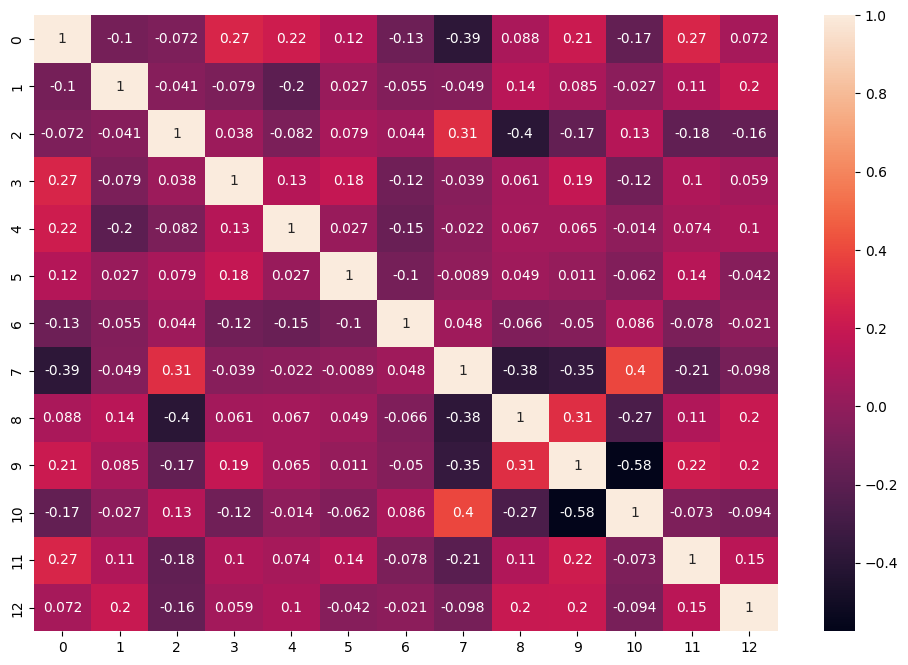

In [31]:
plt.figure(figsize=(12, 8))
sns.heatmap(features.corr(), annot=True)

Максимальная корреляция по модулю = -0.58. Всё не так плохо

Также, чтобы избежать поиска "несуществующих" зависимостей между данными, перекодируем категориальные переменные из метода LabelEncoder с помощью метода OneHotEncoding

In [32]:
features = features.with_columns(
    df.select(["cp", "thal"]).to_dummies()
).select([
    pl.exclude("cp"),
    pl.exclude("thal")
])

features = features.drop(["cp_3", "thal_3"])

DuplicateError: the name 'age' is duplicate

It's possible that multiple expressions are returning the same default column name. If this is the case, try renaming the columns with `.alias("new_name")` to avoid duplicate column names.

In [27]:
features

age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,cp_0,cp_1,cp_2,cp_3,thal_0,thal_1,thal_2,thal_3
i64,i64,i64,i64,i64,i64,i64,i64,i64,f64,i64,i64,i64,u8,u8,u8,u8,u8,u8,u8,u8
52,1,0,125,212,0,1,168,0,1.0,2,2,3,1,0,0,0,0,0,0,1
53,1,0,140,203,1,0,155,1,3.1,0,0,3,1,0,0,0,0,0,0,1
70,1,0,145,174,0,1,125,1,2.6,0,0,3,1,0,0,0,0,0,0,1
61,1,0,148,203,0,1,161,0,0.0,2,1,3,1,0,0,0,0,0,0,1
62,0,0,138,294,1,1,106,0,1.9,1,3,2,1,0,0,0,0,0,1,0
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
59,1,1,140,221,0,1,164,1,0.0,2,0,2,0,1,0,0,0,0,1,0
60,1,0,125,258,0,0,141,1,2.8,1,1,3,1,0,0,0,0,0,0,1
47,1,0,110,275,0,0,118,1,1.0,1,1,2,1,0,0,0,0,0,1,0


In [55]:
X_train, X_test, y_train, y_test = train_test_split(features, targets, test_size=0.2, shuffle=True, stratify=targets)

In [56]:
svm = SVM(X_train, y_train, C=1.0)
svm.fit()

predictions = svm.predict(X_test)

X type: <class 'numpy.ndarray'>, y type: <class 'polars.series.series.Series'>


TypeError: selecting rows by passing a boolean mask to `__getitem__` is not supported

Hint: Use the `filter` method instead.

# 10. Повторение всех задач на новых данных
Набор данных UCI Adult: классификация людей с помощью демографических данных для прогнозирования, зарабатывает ли человек более $ 50 000 в год.

Описание признаков:

Age – возраст, количественный признак

Workclass – тип работодателя, количественный признак

fnlwgt – итоговый вес обьекта, количественный признак

Education – уровень образования, качественный признак

Education_Num – количество лет обучения, количественный признак

Martial_Status – семейное положение, категориальный признак

Occupation – профессия, категориальный признак

Relationship – тип семейных отношений, категориальный признак

Race – раса, категориальный признак

Sex – пол, качественный признак

Capital_Gain – прирост капитала, количественный признак

Capital_Loss – потери капитала, количественный признак

Hours_per_week – количество часов работы в неделю, количественный признак

Country – страна, категориальный признак

**Целевая переменная**: Target – уровень заработка, категориальный (бинарный) признак

In [5]:
df2 = pl.read_csv('adult_data.csv')

In [6]:
df2

age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,salary
i64,str,i64,str,i64,str,str,str,str,str,i64,i64,i64,str,str
39,"""State-gov""",77516,"""Bachelors""",13,"""Never-married""","""Adm-clerical""","""Not-in-family""","""White""","""Male""",2174,0,40,"""United-States""","""<=50K"""
50,"""Self-emp-not-inc""",83311,"""Bachelors""",13,"""Married-civ-spouse""","""Exec-managerial""","""Husband""","""White""","""Male""",0,0,13,"""United-States""","""<=50K"""
38,"""Private""",215646,"""HS-grad""",9,"""Divorced""","""Handlers-cleaners""","""Not-in-family""","""White""","""Male""",0,0,40,"""United-States""","""<=50K"""
53,"""Private""",234721,"""11th""",7,"""Married-civ-spouse""","""Handlers-cleaners""","""Husband""","""Black""","""Male""",0,0,40,"""United-States""","""<=50K"""
28,"""Private""",338409,"""Bachelors""",13,"""Married-civ-spouse""","""Prof-specialty""","""Wife""","""Black""","""Female""",0,0,40,"""Cuba""","""<=50K"""
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
27,"""Private""",257302,"""Assoc-acdm""",12,"""Married-civ-spouse""","""Tech-support""","""Wife""","""White""","""Female""",0,0,38,"""United-States""","""<=50K"""
40,"""Private""",154374,"""HS-grad""",9,"""Married-civ-spouse""","""Machine-op-inspct""","""Husband""","""White""","""Male""",0,0,40,"""United-States""",""">50K"""
58,"""Private""",151910,"""HS-grad""",9,"""Widowed""","""Adm-clerical""","""Unmarried""","""White""","""Female""",0,0,40,"""United-States""","""<=50K"""
